In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tqdm import tqdm


In [5]:

df = pd.read_csv("emnist-mnist-train.csv")
df.columns = [str(i) for i in range(df.shape[1])]  
df.rename(columns={'0': 'label'}, inplace=True)    

data = shuffle(df, random_state=42)


In [7]:

balanced_data = pd.concat([
    data[data['label'] == i].head(100) for i in range(26)
])

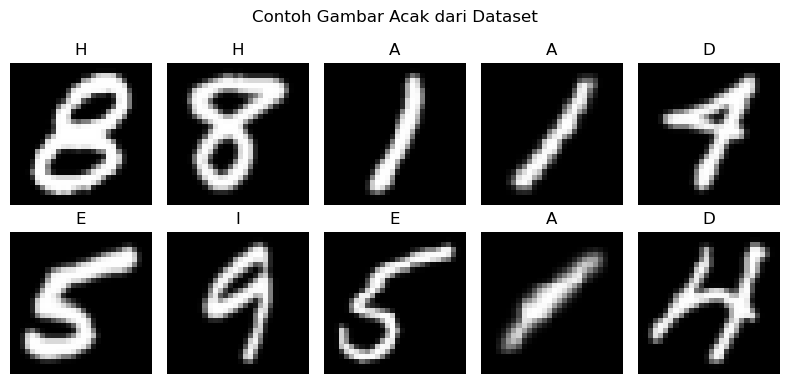

In [9]:

plt.figure(figsize=(8, 4))


sample_data = balanced_data.sample(10, random_state=None).reset_index(drop=True)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_data.iloc[i, 1:].values.reshape(28, 28).T, cmap='gray')  
    plt.title(chr(sample_data.iloc[i, 0] + 64))  
    plt.axis('off')

plt.suptitle("Contoh Gambar Acak dari Dataset")
plt.tight_layout()
plt.show()



In [11]:
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for image in images:
        feature = hog(image, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      block_norm='L2-Hys')
        hog_features.append(feature)
    return np.array(hog_features)

X_images = balanced_data.iloc[:, 1:].values.reshape(-1, 28, 28)
y_labels = balanced_data['label'].values

print("Ekstraksi fitur HOG...")
X_features = extract_hog_features(X_images)


Ekstraksi fitur HOG...


In [13]:

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)


In [15]:

print("Mencari parameter terbaik SVM dengan GridSearchCV...")
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), params, cv=5, n_jobs=-1)
grid.fit(X_features, y_encoded)
print("Best Params:", grid.best_params_)


Mencari parameter terbaik SVM dengan GridSearchCV...
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [16]:

print("Melakukan evaluasi LOOCV dengan 80/20 split...")
y_true, y_pred = [], []

for i in tqdm(range(len(X_features))):
    X_test = X_features[i].reshape(1, -1)
    y_test = [y_encoded[i]]

    X_train = np.delete(X_features, i, axis=0)
    y_train = np.delete(y_encoded, i, axis=0)

    X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    clf = SVC(**grid.best_params_)
    clf.fit(X_train_sub, y_train_sub)
    pred = clf.predict(X_test)

    y_pred.append(pred[0])
    y_true.append(y_test[0])


Melakukan evaluasi LOOCV dengan 80/20 split...


100%|██████████| 1000/1000 [01:34<00:00, 10.60it/s]



Evaluasi Akhir:
Accuracy : 0.9600
Precision: 0.9601
Recall   : 0.9600
F1-Score : 0.9599


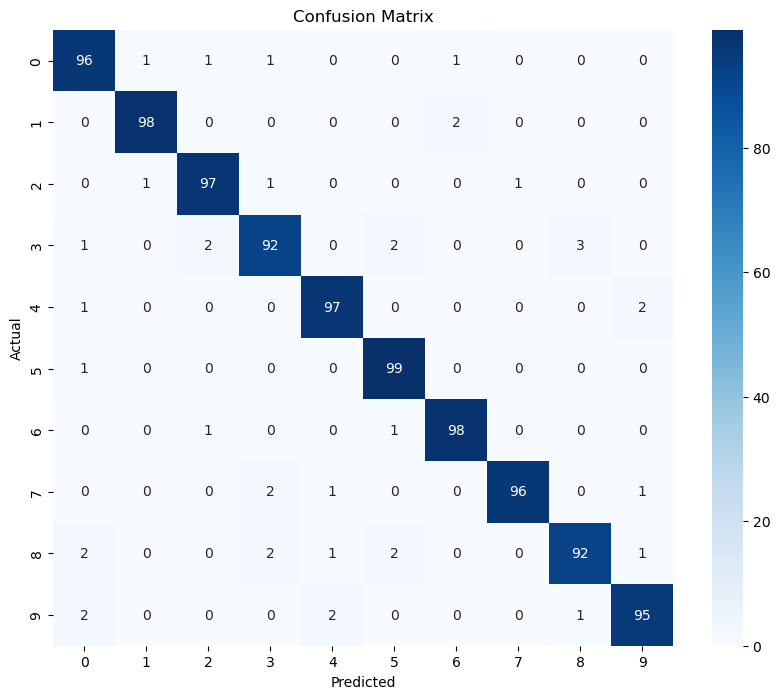

In [18]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
conf = confusion_matrix(y_true, y_pred)

print("\nEvaluasi Akhir:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:

np.savetxt("confusion_matrix.csv", conf, fmt="%d", delimiter=",")
pd.DataFrame({
    "True": label_encoder.inverse_transform(y_true),
    "Pred": label_encoder.inverse_transform(y_pred)
}).to_csv("hasil_prediksi.csv", index=False)

print("Hasil evaluasi dan prediksi disimpan.")


Hasil evaluasi dan prediksi disimpan.
